In [1]:
import os
import numpy as np
import pandas as pd
import mne
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import json

In [2]:
def load_ieeg_data(subject_id, data_dir, task='film', acquisition='clinical', run=1):
    """Load iEEG data for a specific subject from BIDS format"""
    data_dir = Path(data_dir)
    subject_dir = data_dir / subject_id / 'ses-iemu' / 'ieeg'
    base_name = f"{subject_id}_ses-iemu_task-{task}_acq-{acquisition}_run-{run}"
    
    vhdr_file = subject_dir / f"{base_name}_ieeg.vhdr"
    raw = mne.io.read_raw_brainvision(vhdr_file, preload=True, verbose=False)
    
    events_file = subject_dir / f"{subject_id}_ses-iemu_task-{task}_run-{run}_events.tsv"
    events_df = pd.read_csv(events_file, sep='\t')
    
    channels_file = subject_dir / f"{base_name}_channels.tsv"
    channels_df = pd.read_csv(channels_file, sep='\t')
    
    return raw, events_df, channels_df

In [3]:
def get_channels_by_type(raw, channels_df, channel_types, subject_id):
    """
    Get channels of specific types that are marked as 'good'
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw data object
    channels_df : pd.DataFrame
        Channels information dataframe
    channel_types : list of str
        List of channel types to extract (e.g., ['SEEG', 'ECOG'])
    
    Returns:
    --------
    channels : list of str
        List of channel names
    """
    with open("./perisylvian_data.json", "r") as f:
        all_subject_perisylvian_channels = json.load(f)
        
    current_subject_perisylvian = all_subject_perisylvian_channels.get(subject_id, [])

    if current_subject_perisylvian:
        current_subject_perisylvian = set(current_subject_perisylvian.keys())

    if "SEEG" in channel_types or "ECOG" in channel_types:
        print((current_subject_perisylvian))
        good_channels = channels_df[
            (channels_df['status'] == 'good') &
            (channels_df['type'].isin(channel_types)) & 
            (channels_df['name'].isin(current_subject_perisylvian))
        ]['name'].tolist()
    else:
        good_channels = channels_df[
            (channels_df['status'] == 'good') &
            (channels_df['type'].isin(channel_types))
        ]['name'].tolist()
    
    # Filter to only those present in raw data
    channels = [ch for ch in good_channels if ch in raw.ch_names]
    
    return channels

In [4]:
DATA_DIR = r"C:\DS003688\DS003688"
SUBJECT_ID = "sub-05"

print(f"Processing {SUBJECT_ID}...")

# Load data
raw, events_df, channels_df = load_ieeg_data(SUBJECT_ID, DATA_DIR)

print(f"\nRaw data shape: {raw._data.shape}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Recording duration: {raw.times[-1]:.2f} seconds")

Processing sub-05...

Raw data shape: (97, 1083322)
Sampling frequency: 2048.0 Hz
Recording duration: 528.97 seconds


In [5]:
print(channels_df.head())

  name  type units  low_cutoff  high_cutoff reference group status  \
0  T01  ECOG    µV         NaN         0.15        G2     T   good   
1  T02  ECOG    µV         0.0         0.15        G2     T   good   
2  T03  ECOG    µV         0.0         0.15        G2     T   good   
3  T04  ECOG    µV         0.0         0.15        G2     T   good   
4  T05  ECOG    µV         0.0         0.15        G2     T   good   

  status_description  sampling_frequency  
0                NaN              2048.0  
1                NaN              2048.0  
2                NaN              2048.0  
3                NaN              2048.0  
4                NaN              2048.0  


In [6]:
ieeg_channels = get_channels_by_type(raw, channels_df, ['SEEG', 'ECOG'], SUBJECT_ID)

# Get reference channels for artifact detection
eog_channels = get_channels_by_type(raw, channels_df, ['EOG'], SUBJECT_ID)
ecg_channels = get_channels_by_type(raw, channels_df, ['ECG'], SUBJECT_ID)
emg_channels = get_channels_by_type(raw, channels_df, ['EMG'], SUBJECT_ID)

print(f"\niEEG channels: {len(ieeg_channels)}")
print(f"EOG channels: {eog_channels}")
print(f"ECG channels: {ecg_channels}")
print(f"EMG channels: {emg_channels}")

{'T24', 'T21', 'T32', 'T13', 'T29', 'C56', 'C63', 'C62', 'T22', 'T28', 'C61', 'sT7', 'T23', 'C60', 'T16', 'T31', 'T26', 'T27', 'T30', 'C55', 'T15', 'vT5', 'C64', 'C58', 'C59', 'vT6', 'T14', 'sT6'}

iEEG channels: 25
EOG channels: ['orb+']
ECG channels: ['ECG+']
EMG channels: ['emg1+', 'EMG2', 'thor+', 'abdo+']


In [7]:
# Raw object with ONLY iEEG channels (for ICA fitting)
raw_ieeg = raw.copy().pick_channels(ieeg_channels)

# Raw object with ALL good channels (for artifact detection)
all_channels = ieeg_channels + eog_channels + ecg_channels + emg_channels
raw_all = raw.copy().pick_channels(all_channels)

print(f"\nraw_ieeg channels: {len(raw_ieeg.ch_names)}")
print(f"raw_all channels: {len(raw_all.ch_names)}")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

raw_ieeg channels: 25
raw_all channels: 31


In [8]:
# Filter BOTH raw objects with the same parameters
raw_ieeg_filt = raw_ieeg.copy().filter(l_freq=1.0, h_freq=None, fir_design='firwin')
raw_all_filt = raw_all.copy().filter(l_freq=1.0, h_freq=None, fir_design='firwin')

print("\nHigh-pass filter (1 Hz) applied to both datasets")

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)


High-pass filter (1 Hz) applied to both datasets


In [9]:
print("\nFitting ICA on iEEG channels only...")
ica = mne.preprocessing.ICA(
    n_components=0.99,
    method='fastica',
    random_state=97,
    max_iter=800
)

# Fit on filtered iEEG data
ica.fit(raw_ieeg_filt, decim=3)


Fitting ICA on iEEG channels only...
Fitting ICA to data using 25 channels (please be patient, this may take a while)
Selecting by explained variance: 20 components
Fitting ICA took 18.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,29 iterations on raw data (361108 samples)
ICA components,20
Available PCA components,25
Channel types,eeg
ICA components marked for exclusion,—


In [10]:
# KEY INSIGHT: We need to get ICA sources from the iEEG data,
# but correlate them with the reference channels (EOG/ECG/EMG)

# Get ICA sources from iEEG channels
ica_sources = ica.get_sources(raw_ieeg_filt)


Detecting EOG artifacts using channels: ['orb+']
EOG components detected: []


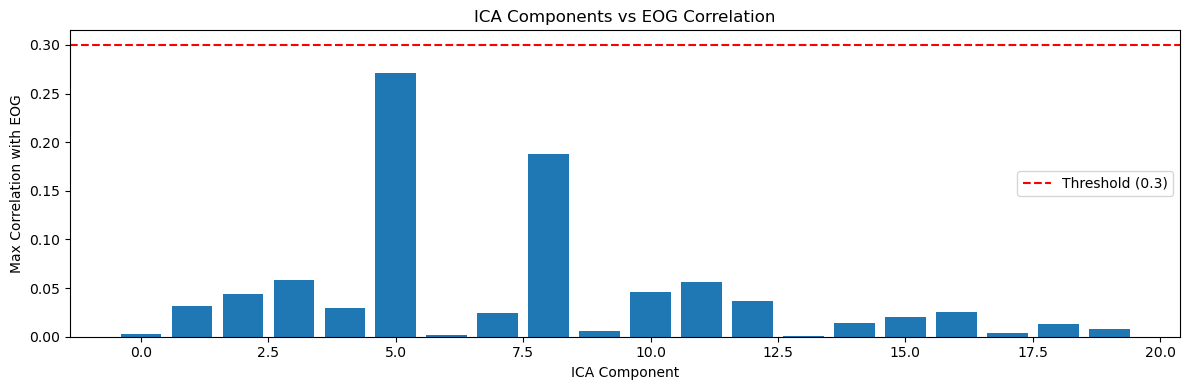

In [11]:
# --- EOG Artifact Detection ---
eog_indices = []
if len(eog_channels) > 0:
    print(f"\nDetecting EOG artifacts using channels: {eog_channels}")
    
    # Get ICA source data
    sources_data = ica_sources.get_data()
    
    # Get EOG data from raw_all_filt
    eog_data = raw_all_filt.get_data(picks=eog_channels)
    
    eog_correlations = []
    for comp_idx in range(ica.n_components_):
        comp_signal = sources_data[comp_idx, :]
        
        # Correlate with all EOG channels and take max absolute correlation
        max_corr = 0
        for eog_idx in range(len(eog_channels)):
            eog_signal = eog_data[eog_idx, :]
            corr = np.abs(np.corrcoef(comp_signal, eog_signal)[0, 1])
            max_corr = max(max_corr, corr)
        
        eog_correlations.append(max_corr)
    
    # Threshold for EOG (typically 0.3-0.5 for correlation)
    eog_threshold = 0.3
    eog_indices = [i for i, corr in enumerate(eog_correlations) if corr > eog_threshold]
    
    print(f"EOG components detected: {eog_indices}")
    
    # Plot EOG correlations
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(eog_correlations)), eog_correlations)
    ax.axhline(y=eog_threshold, color='r', linestyle='--', label=f'Threshold ({eog_threshold})')
    ax.set_xlabel('ICA Component')
    ax.set_ylabel('Max Correlation with EOG')
    ax.set_title('ICA Components vs EOG Correlation')
    if len(eog_indices) > 0:
        for idx in eog_indices:
            ax.bar(idx, eog_correlations[idx], color='red', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()


Detecting ECG artifacts using channels: ['ECG+']
ECG components detected: []


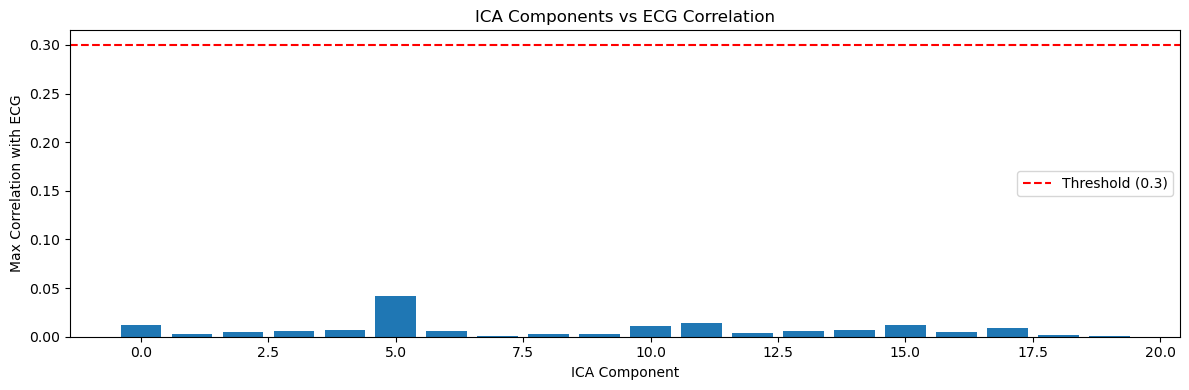

In [12]:
# --- ECG Artifact Detection ---
ecg_indices = []
if len(ecg_channels) > 0:
    print(f"\nDetecting ECG artifacts using channels: {ecg_channels}")
    
    sources_data = ica_sources.get_data()
    ecg_data = raw_all_filt.get_data(picks=ecg_channels)
    
    ecg_correlations = []
    for comp_idx in range(ica.n_components_):
        comp_signal = sources_data[comp_idx, :]
        
        max_corr = 0
        for ecg_idx in range(len(ecg_channels)):
            ecg_signal = ecg_data[ecg_idx, :]
            corr = np.abs(np.corrcoef(comp_signal, ecg_signal)[0, 1])
            max_corr = max(max_corr, corr)
        
        ecg_correlations.append(max_corr)
    
    ecg_threshold = 0.3
    ecg_indices = [i for i, corr in enumerate(ecg_correlations) if corr > ecg_threshold]
    
    print(f"ECG components detected: {ecg_indices}")
    
    # Plot ECG correlations
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(ecg_correlations)), ecg_correlations)
    ax.axhline(y=ecg_threshold, color='r', linestyle='--', label=f'Threshold ({ecg_threshold})')
    ax.set_xlabel('ICA Component')
    ax.set_ylabel('Max Correlation with ECG')
    ax.set_title('ICA Components vs ECG Correlation')
    if len(ecg_indices) > 0:
        for idx in ecg_indices:
            ax.bar(idx, ecg_correlations[idx], color='red', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()


Detecting EMG artifacts using channels: ['emg1+', 'EMG2', 'thor+', 'abdo+']
EMG components detected: []


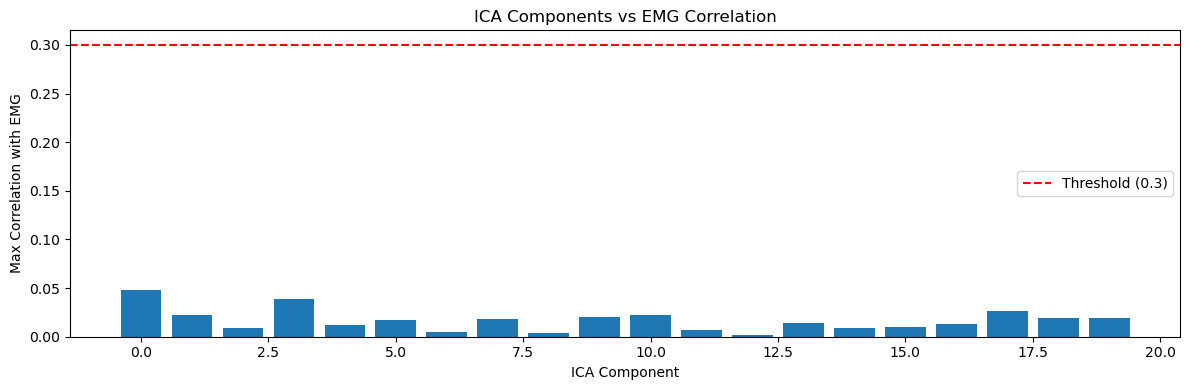

In [13]:
# --- EMG Artifact Detection ---
emg_indices = []
if len(emg_channels) > 0:
    print(f"\nDetecting EMG artifacts using channels: {emg_channels}")
    
    sources_data = ica_sources.get_data()
    emg_data = raw_all_filt.get_data(picks=emg_channels)
    
    emg_correlations = []
    for comp_idx in range(ica.n_components_):
        comp_signal = sources_data[comp_idx, :]
        
        max_corr = 0
        for emg_idx in range(len(emg_channels)):
            emg_signal = emg_data[emg_idx, :]
            corr = np.abs(np.corrcoef(comp_signal, emg_signal)[0, 1])
            max_corr = max(max_corr, corr)
        
        emg_correlations.append(max_corr)
    
    emg_threshold = 0.3
    emg_indices = [i for i, corr in enumerate(emg_correlations) if corr > emg_threshold]
    
    print(f"EMG components detected: {emg_indices}")
    
    # Plot EMG correlations
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(emg_correlations)), emg_correlations)
    ax.axhline(y=emg_threshold, color='r', linestyle='--', label=f'Threshold ({emg_threshold})')
    ax.set_xlabel('ICA Component')
    ax.set_ylabel('Max Correlation with EMG')
    ax.set_title('ICA Components vs EMG Correlation')
    if len(emg_indices) > 0:
        for idx in emg_indices:
            ax.bar(idx, emg_correlations[idx], color='red', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [14]:
all_artifact_indices = list(set(eog_indices + ecg_indices + emg_indices))
ica.exclude = all_artifact_indices

print(f"\nTotal artifact components to remove: {len(all_artifact_indices)}")
print(f"Component indices: {all_artifact_indices}")


Total artifact components to remove: 0
Component indices: []


In [15]:
# CRITICAL: Apply ICA to the same filtered data it was trained on
raw_ieeg_clean = raw_ieeg_filt.copy()
ica.apply(raw_ieeg_clean)

print("\nICA applied successfully to iEEG channels!")

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 25 PCA components

ICA applied successfully to iEEG channels!



Generating before/after comparison...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 25 PCA components


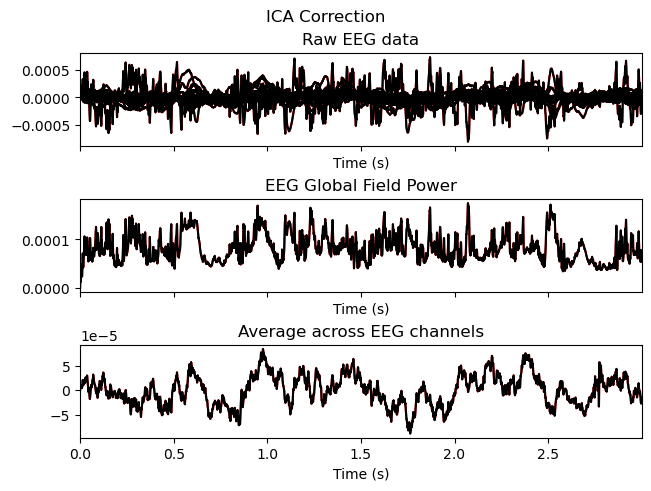

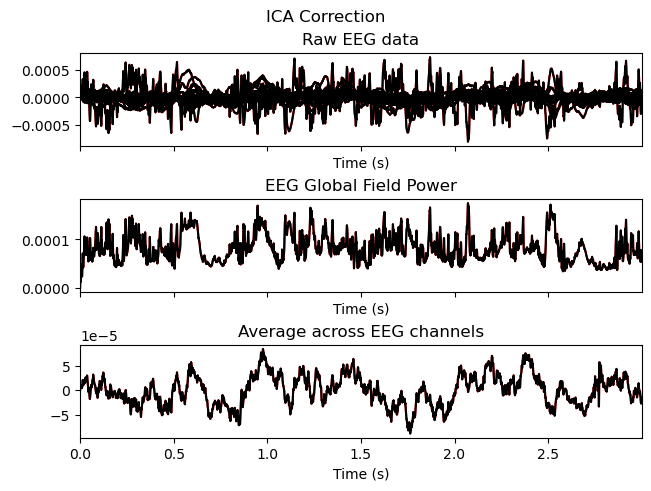

In [16]:
print("\nGenerating before/after comparison...")

# Plot overlay comparison
ica.plot_overlay(raw_ieeg_filt, exclude=ica.exclude, title='ICA Correction')

In [ ]:
# Compare time series before and after
print("\nComparing time series (first 20 seconds)...")

# Plot before ICA
print("Before ICA:")
raw_ieeg_filt.plot(duration=20, n_channels=30, scalings='auto', 
                    title='Before ICA Artifact Removal')

# Plot after ICA
print("After ICA:")
raw_ieeg_clean.plot(duration=20, n_channels=30, scalings='auto', 
                     title='After ICA Artifact Removal')

print("\nProcessing complete!")
print(f"Clean data shape: {raw_ieeg_clean._data.shape}")
print(f"Components removed: {len(all_artifact_indices)} out of {ica.n_components_}")

In [17]:
# Display events info
print("\nEvents in the data:")
print(events_df[['onset', 'duration', 'trial_type', 'value']])


Events in the data:
      onset  duration  trial_type  value
0   115.429     0.017  start task      9
1   115.446    29.998       music      2
2   145.444    30.000      speech      1
3   175.444    30.000       music      2
4   205.444    30.001      speech      1
5   235.445    29.999       music      2
6   265.444    30.000      speech      1
7   295.444    30.001       music      2
8   325.445    30.000      speech      1
9   355.445    30.000       music      2
10  385.445    30.000      speech      1
11  415.445    30.000       music      2
12  445.445    30.000      speech      1
13  475.445    30.043       music      2
14  505.488     0.000    end task      4


In [18]:
def notch_filter(raw, freqs=[50, 100, 150]):
    """
    Apply a notch filter to the raw iEEG data to remove power line noise.

    Parameters:
    -----------
    raw : mne.io.Raw
        The raw iEEG data.
    freqs : list of float
        The frequencies to filter out (in Hz). Defaults to 50 Hz and its
        first two harmonics.

    Returns:
    --------
    raw_notched : mne.io.Raw
        The notch-filtered data.
    """
    print(f"\nApplying notch filter at {freqs} Hz...")
    raw_notched = raw.copy().notch_filter(
        freqs=freqs,
        fir_design='firwin',
        verbose=False
    )
    print("Notch filtering complete.")
    return raw_notched

In [19]:
raw_notched = notch_filter(raw_ieeg_clean)


Applying notch filter at [50, 100, 150] Hz...
Notch filtering complete.


Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


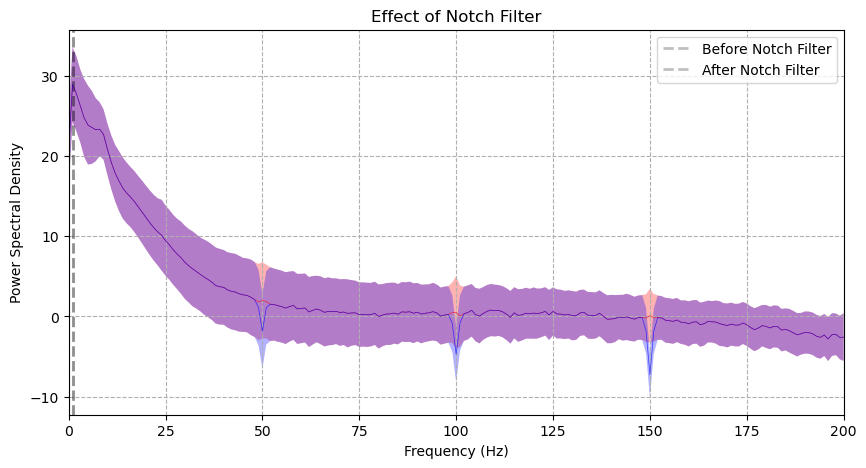

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot PSD before filtering (in red)
raw_ieeg_clean.compute_psd(fmax=200).plot(axes=ax, color='red', show=False, average=True, alpha=0.7)

# Plot PSD after filtering (in blue)
raw_notched.compute_psd(fmax=200).plot(axes=ax, color='blue', show=False, average=True, alpha=0.7)

ax.set_title("Effect of Notch Filter")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density")
ax.legend(['Before Notch Filter', 'After Notch Filter'])
plt.grid(True, linestyle='--')
plt.show();

In [21]:
def bandpass_filter(raw, l_freq=0.1, h_freq=200.0):
    """
    Apply a band-pass filter to the raw iEEG data to remove slow drifts
    and high-frequency noise.

    Parameters:
    -----------
    raw : mne.io.Raw
        The raw iEEG data.
    l_freq : float
        The lower bound of the filter (in Hz).
    h_freq : float
        The upper bound of the filter (in Hz).

    Returns:
    --------
    raw_filtered : mne.io.Raw
        The band-pass filtered data.
    """
    print(f"\nApplying band-pass filter ({l_freq}-{h_freq} Hz)...")
    raw_filtered = raw.copy().filter(
        l_freq=l_freq, 
        h_freq=h_freq, 
        fir_design='firwin', 
        verbose=False
    )
    print("Filtering complete.")
    return raw_filtered

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).

Applying band-pass filter (0.1-200.0 Hz)...
Filtering complete.
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


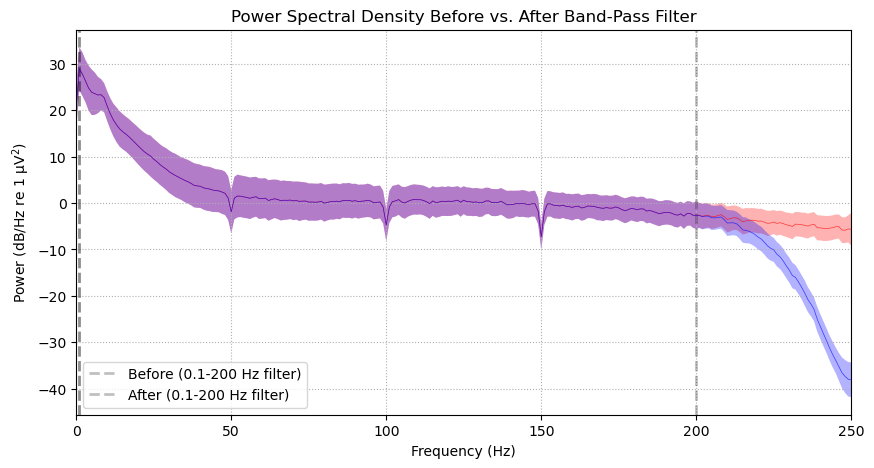

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot PSD before filtering (in red)
raw_notched.compute_psd(fmax=250).plot(axes=ax, color='red', show=False, average=True, alpha=0.7)

raw_bandpass = bandpass_filter(raw_notched)
# Plot PSD after filtering (in blue)
raw_bandpass.compute_psd(fmax=250).plot(axes=ax, color='blue', show=False, average=True, alpha=0.7)

ax.set_title("Power Spectral Density Before vs. After Band-Pass Filter")
ax.legend(['Before (0.1-200 Hz filter)', 'After (0.1-200 Hz filter)']) # Corrected legend
plt.show()

Setting up band-pass filter from 0.1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 67585 samples (33.000 s)



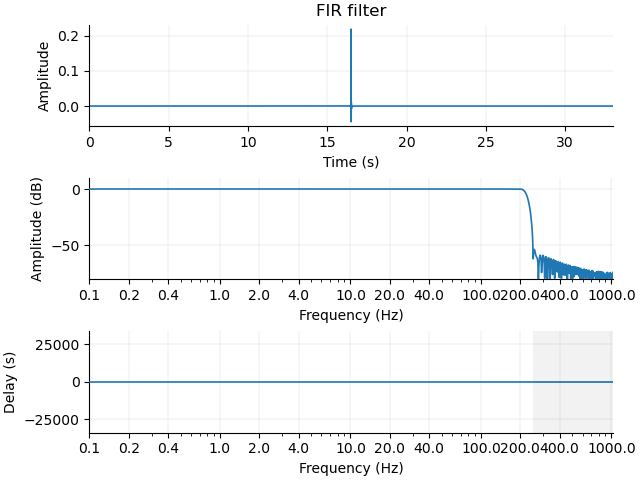

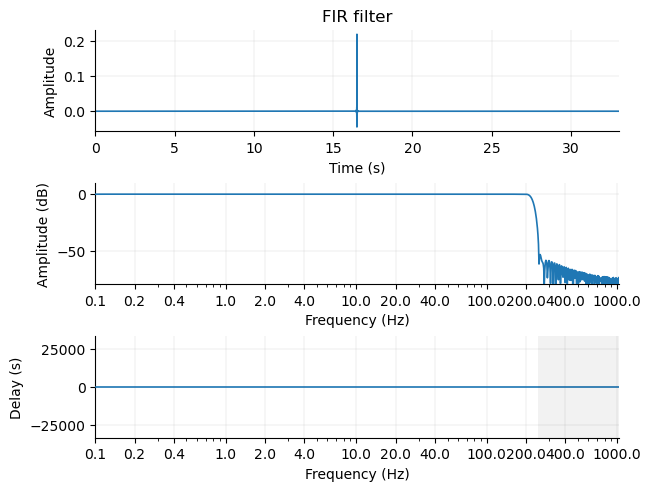

In [23]:
%matplotlib widget

filter_params = mne.filter.create_filter(
    raw_notched.get_data(), raw_notched.info["sfreq"], l_freq=0.1, h_freq=200, fir_design='firwin'
)

mne.viz.plot_filter(filter_params, raw_notched.info["sfreq"])

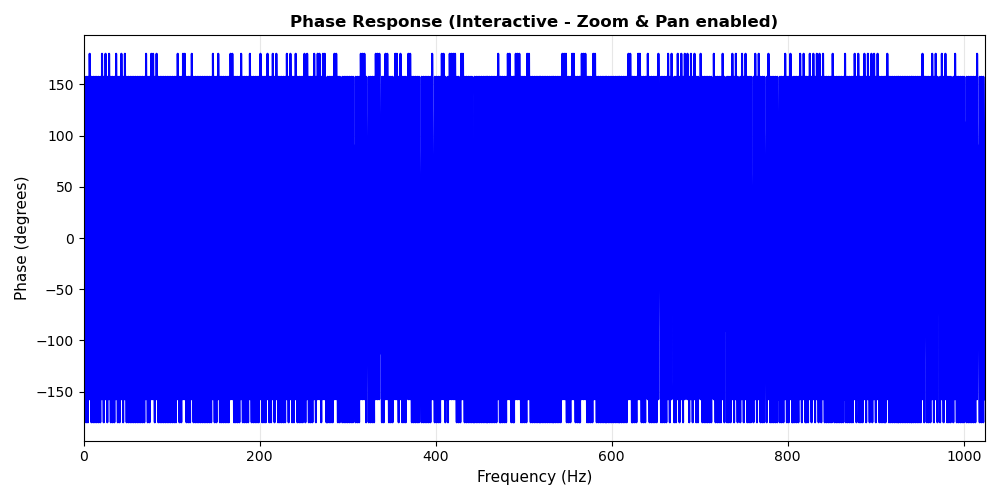

In [24]:
from scipy import signal
%matplotlib widget

sfreq = raw_notched.info["sfreq"]
w, h = signal.freqz(filter_params, worN=8192, fs=sfreq)

# Calculate phase response in degrees
phase_deg = np.degrees(np.angle(h))

# Plot wrapped phase response
plt.figure(figsize=(10, 5))
plt.plot(w, phase_deg, 'b-', linewidth=1.5)
plt.xlabel('Frequency (Hz)', fontsize=11)
plt.ylabel('Phase (degrees)', fontsize=11)
plt.title('Phase Response (Interactive - Zoom & Pan enabled)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim([0, sfreq/2])
plt.tight_layout()
plt.show()

In [25]:
def reference(raw):
    """
    Apply Common Average Reference (CAR) to iEEG data.
    
    Temporarily sets the channel type to 'eeg' to use MNE's built-in
    referencing function, then sets it back.
    """
    # Create a copy to avoid modifying the original data
    raw_copy = raw.copy()
    
    # 1. Get the original channel types to restore them later
    original_ch_types = raw_copy.get_channel_types()
    
    # 2. Temporarily set the iEEG channel types to 'eeg'
    # This is necessary because set_eeg_reference only works on 'eeg' channels.
    mapping = {ch_name: 'eeg' for ch_name in raw_copy.ch_names}
    raw_copy.set_channel_types(mapping)
    
    # 3. Apply the common average reference
    # The function will now find and process the channels.
    raw_car, _ = mne.set_eeg_reference(raw_copy, 'average', projection=False)
    
    # 4. Set the channel types back to their original values
    original_mapping = {ch_name: ch_type for ch_name, ch_type in zip(raw_copy.ch_names, original_ch_types)}
    raw_car.set_channel_types(original_mapping)
    
    return raw_car


--- Generating Corrected Before-and-After Plots ---
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


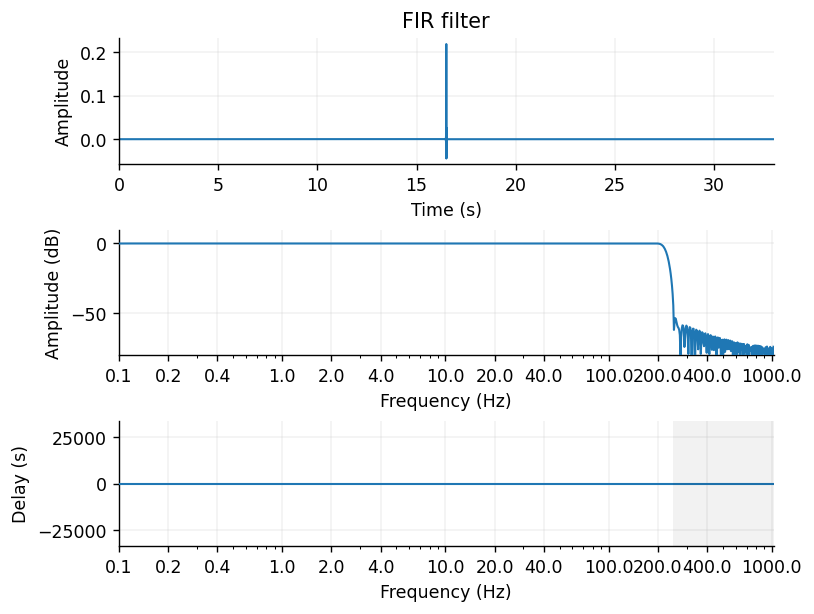

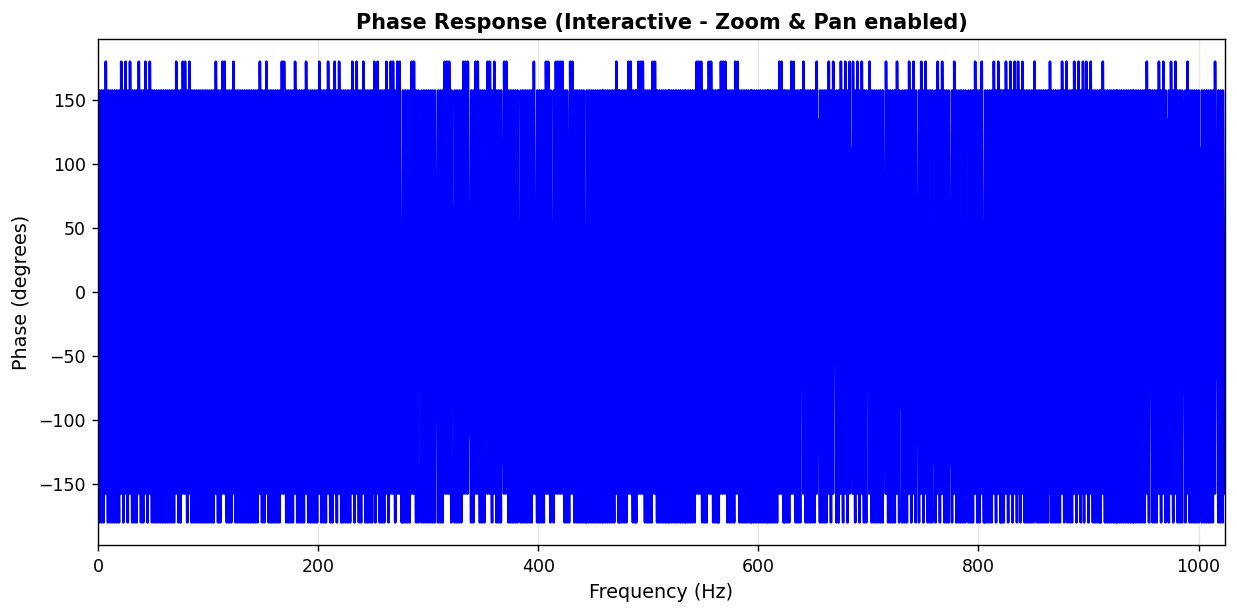

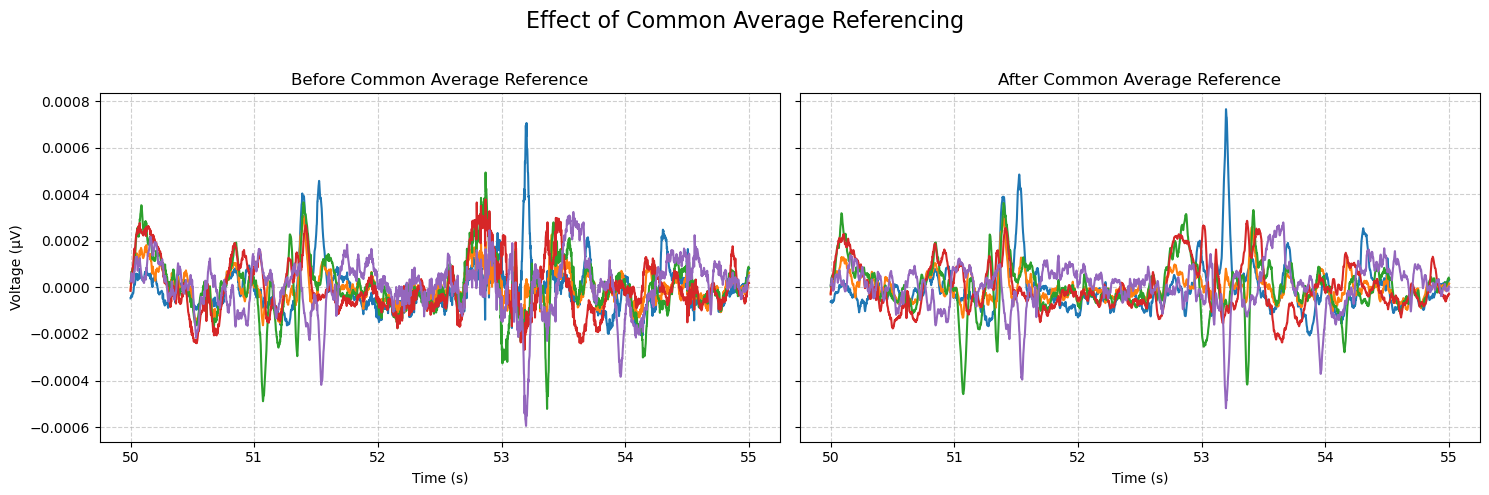

In [26]:
%matplotlib inline

print("\n--- Generating Corrected Before-and-After Plots ---")

# Choose a few channels and a short time window to compare
channels_to_plot = raw_bandpass.ch_names[:5]
start_time, stop_time = 50, 55 # A 5-second window
sfreq = raw_bandpass.info['sfreq']

# Get data segment BEFORE referencing from the original object
data_before, times = raw_bandpass.get_data(
    picks=channels_to_plot, 
    start=int(start_time * sfreq), 
    stop=int(stop_time * sfreq),
    return_times=True
)

# Apply referencing to create a NEW object
raw_referenced = reference(raw_bandpass)

# Get data segment AFTER referencing from the NEW object
data_after = raw_referenced.get_data(
    picks=channels_to_plot, 
    start=int(start_time * sfreq), 
    stop=int(stop_time * sfreq)
)

# Plot them side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax1.plot(times, data_before.T)
ax1.set_title("Before Common Average Reference")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (µV)")
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(times, data_after.T)
ax2.set_title("After Common Average Reference")
ax2.set_xlabel("Time (s)")
ax2.grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Effect of Common Average Referencing", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


MNE events created: 13 events
Event types: {'speech': 1, 'music': 2}
[ 1.  2.  4.  8. 16. 32. 64.]
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: zscore)
No baseline correction applied


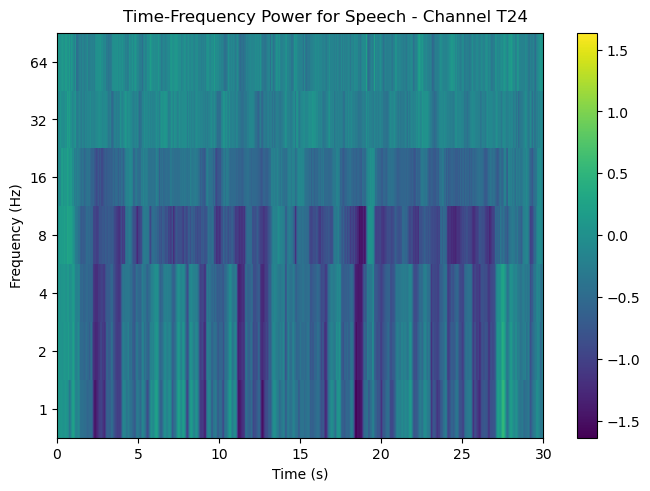

No baseline correction applied


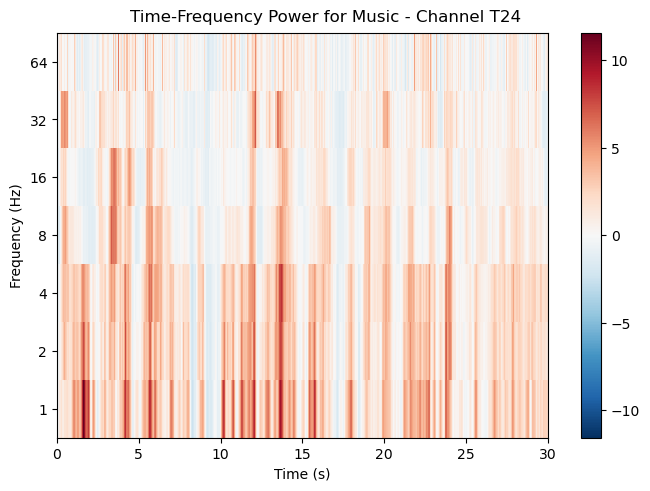

[<Figure size 640x480 with 2 Axes>]

In [27]:
def create_mne_events(events_df, raw):
    """
    Convert BIDS events to MNE events format
    
    Parameters:
    -----------
    events_df : pd.DataFrame
        BIDS events dataframe
    raw : mne.io.Raw
        Raw data for sampling frequency
    
    Returns:
    --------
    events : np.ndarray
        MNE events array (n_events, 3)
    event_id : dict
        Event ID mapping
    """
    
    # Convert onset times to samples
    sfreq = raw.info['sfreq']
    
    # Filter for speech and music events only
    speech_music_events = events_df[events_df['trial_type'].isin(['speech', 'music'])].copy()
    
    # Create MNE events array
    n_events = len(speech_music_events)
    events = np.zeros((n_events, 3), dtype=int)
    
    # Sample numbers (onset times * sampling frequency)
    events[:, 0] = (speech_music_events['onset'] * sfreq).astype(int)
    events[:, 1] = 0  # Duration (not used in MNE events)
    
    # Event codes: speech=1, music=2
    event_id = {'speech': 1, 'music': 2}
    for i, trial_type in enumerate(speech_music_events['trial_type']):
        events[i, 2] = event_id[trial_type]
    
    return events, event_id

# Create MNE events
events, event_id = create_mne_events(events_df, raw_referenced)
print(f"\nMNE events created: {len(events)} events")
print("Event types:", event_id)

def epoch_ieeg_data(raw, events, event_id, tmin=-2.0, tmax=32.0):
    """
    Create epochs from raw iEEG data (without MNE baseline correction)
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw iEEG data
    events : np.ndarray
        MNE events array
    event_id : dict
        Event ID mapping
    tmin : float
        Start time relative to event (seconds)
    tmax : float
        End time relative to event (seconds)
    
    Returns:
    --------
    epochs : mne.Epochs
        Epoched data (no baseline correction applied)
    """
    
    # Create epochs without baseline correction
    epochs = mne.Epochs(
        raw, 
        events, 
        event_id,
        tmin=tmin, 
        tmax=tmax,
        baseline=None,  # No MNE baseline correction
        preload=True,
        verbose=False
    )
    
    return epochs

tmin = -2.0
tmax = 32.0
epochs = epoch_ieeg_data(raw_referenced, events, event_id, tmin=tmin, tmax=tmax)

# 3. Use better frequency/cycle parameters
freqs = np.logspace(0, 6, 7, base=2)

n_cycles = freqs / 2  # More cycles = better frequency resolution
print(freqs)

# n_cycles = [5]*len(freqs)
# # print(n_cycles)

# 4. Compute TFR with averaging
tfr_speech = mne.time_frequency.tfr_multitaper(
    epochs['speech'], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    use_fft=True, 
    return_itc=False,
    average=True
)

tfr_music = mne.time_frequency.tfr_multitaper(
    epochs['music'], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    use_fft=True, 
    return_itc=False,
)

# 5. Crop to your time window of interest
tfr_speech.apply_baseline(baseline=(-2, 0), mode='logratio')
tfr_speech.crop(tmin=0, tmax=30)
tfr_music.apply_baseline(baseline=(-2, 0), mode='zscore')
tfr_music.crop(tmin=0, tmax=30)

# 5. Plot the results for a specific channel
channel_to_plot = 'T24' # Pick a channel of interest

tfr_speech.plot(
    picks=[channel_to_plot], 
    title=f'Time-Frequency Power for Speech - Channel {channel_to_plot}',
    tmin=0, tmax=30,
    cmap="viridis"
)

# for epoch_idx in range(min(5, len(tfr_speech))):
#     tfr_single = tfr_speech[epoch_idx]  # Select single epoch

#     tfr_avg = tfr_single.average()
    
#     tfr_avg.plot(
#         picks=[channel_to_plot],
#         title=f'Epoch {epoch_idx} - Channel {channel_to_plot}',
#         tmin=0, tmax=30,
#         cmap="viridis",
#         vmin=-2, vmax=2
#     )

# Plot the TFR for the Music condition
tfr_music.plot(
    picks=[channel_to_plot], 
    title=f'Time-Frequency Power for Music - Channel {channel_to_plot}',
    tmin=0, tmax=30
)

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


C:\Users\prajwalj\AppData\Local\Temp\ipykernel_10156\2335392597.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['speech'].plot_image(picks=[channel_to_plot],


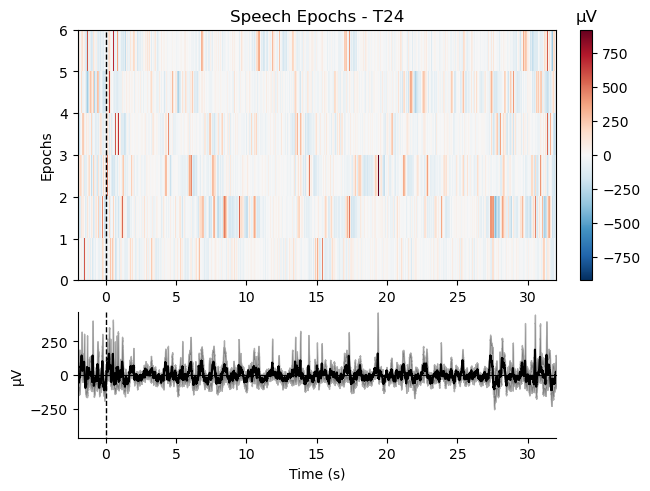

[<Figure size 640x480 with 3 Axes>]

In [28]:
epochs['speech'].plot_image(picks=[channel_to_plot], 
                            title=f'Speech Epochs - {channel_to_plot}')

Need more than one channel to make topography for eeg. Disabling interactivity.


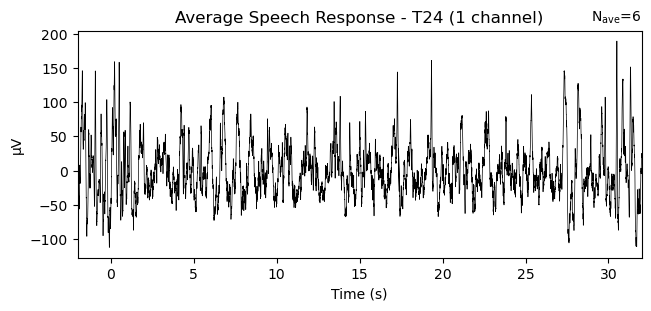

Need more than one channel to make topography for eeg. Disabling interactivity.


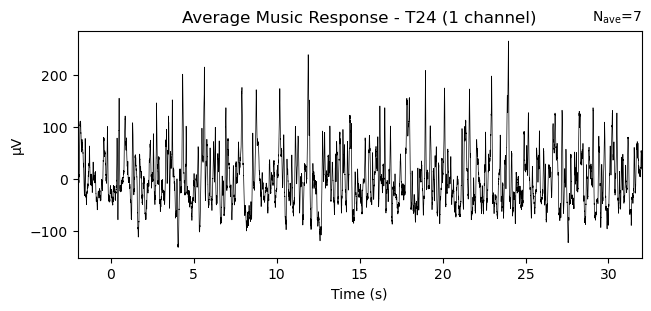

C:\Users\prajwalj\AppData\Local\Temp\ipykernel_10156\1416458386.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds({'Speech': evoked_speech, 'Music': evoked_music},


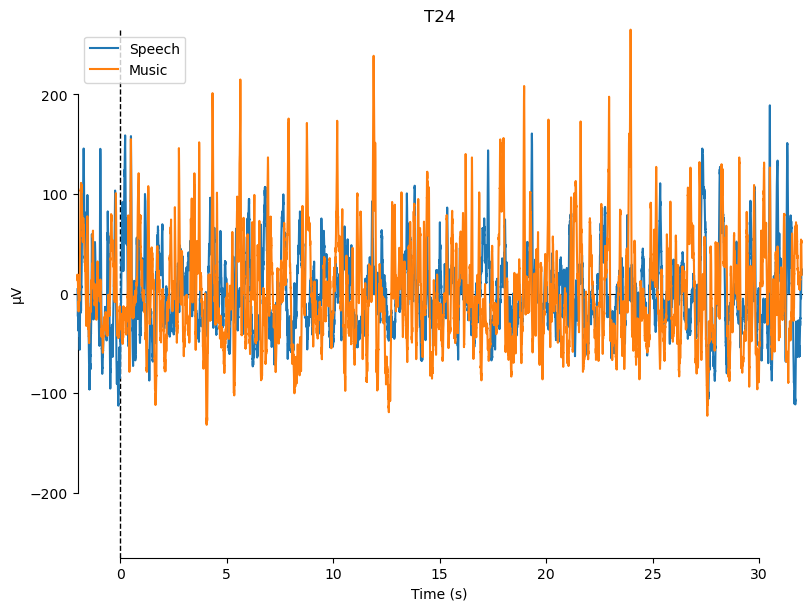

[<Figure size 800x600 with 1 Axes>]

In [29]:
evoked_speech = epochs['speech'].average()
evoked_music = epochs['music'].average()

# Plot single channel
evoked_speech.plot(picks=[channel_to_plot], titles=f'Average Speech Response - {channel_to_plot}')
evoked_music.plot(picks=[channel_to_plot], titles=f'Average Music Response - {channel_to_plot}')

# Compare conditions
mne.viz.plot_compare_evokeds({'Speech': evoked_speech, 'Music': evoked_music}, 
                             picks=[channel_to_plot])

In [30]:
def extract_hfb_power(raw):
    """
    Extract High-Frequency Band (HFB) power (4-8 Hz) from raw iEEG data.

    This function filters the data in the HFB range and then applies the Hilbert
    transform to compute the signal's power envelope.

    Parameters:
    -----------
    raw : mne.io.Raw
        Preprocessed continuous iEEG data.

    Returns:
    --------
    raw_hfb : mne.io.Raw
        Continuous iEEG data with HFB power instead of voltage.
    """
    print("\nExtracting High-Frequency Band (60-120 Hz) power...")
    
    # 1. Band-pass filter in the HFB range (60-120 Hz)
    raw_hfb = raw.copy().filter(l_freq=4., h_freq=8., fir_design='firwin', verbose=False)

    # 2. Apply Hilbert transform to get the envelope (power) of the signal
    raw_hfb.apply_hilbert(envelope=True)
    
    print("HFB power extraction complete.")
    return raw_hfb

# def apply_hilbert(raw):
#     """
#     Extract High-Frequency Band (HFB) power (60-120 Hz) from raw iEEG data.

#     This function filters the data in the HFB range and then applies the Hilbert
#     transform, manually taking the absolute value to compute the signal's 
#     power envelope reliably.
#     """    
#     # 1. Band-pass filter in the HFB range (60-120 Hz)
#     # raw_hfb = raw.copy().filter(l_freq=60., h_freq=120., fir_design='firwin', verbose=False)

#     raw_hfb = raw.copy()

#     # 2. Apply Hilbert transform to get the complex analytic signal
#     # We set envelope=False to get the complex number output
#     raw_hfb.apply_hilbert(envelope=False)
    
#     # 3. Manually compute the envelope by taking the absolute value
#     # This is the most reliable way to get the power envelope
#     hfb_envelope_data = np.abs(raw_hfb.get_data())
#     phase_angles = np.degrees(np.angle(raw_hfb.get_data()))
    
#     # 4. Create a new Raw object with the envelope data
#     raw_hfb_power = mne.io.RawArray(hfb_envelope_data, raw_hfb.info)
    
#     print("Applied Hilbert")
#     return raw_hfb_power, phase_angles


Extracting High-Frequency Band (60-120 Hz) power...
HFB power extraction complete.


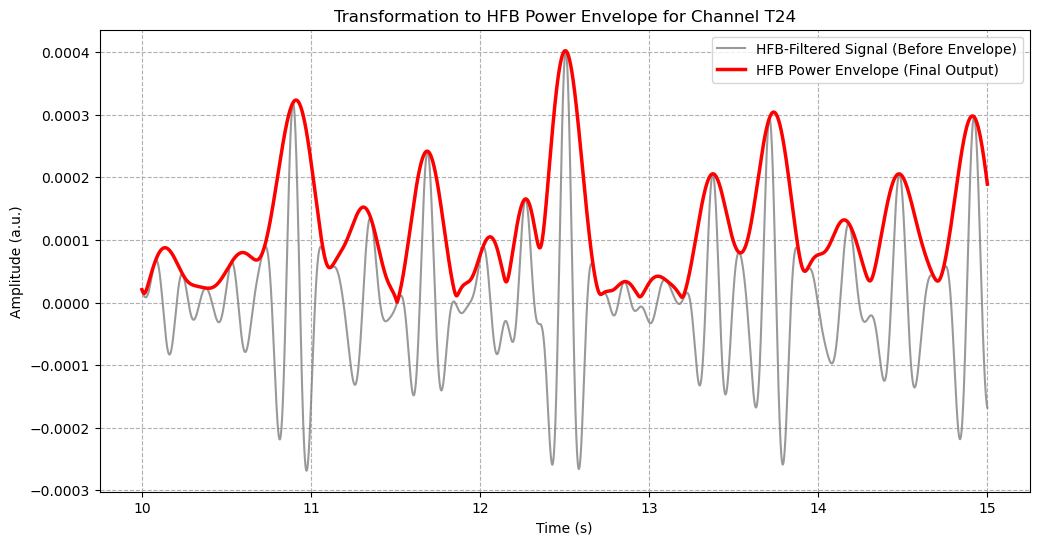

In [31]:
# --- Visualization to confirm the transformation ---

# First, let's re-run the first two steps to get the intermediate signal
before_hilbert = raw_referenced.copy()

# Get a short snippet of the HFB-filtered data (still an oscillating wave)
channel_to_plot = 'T24' # Pick one of the channel names
start_time, stop_time = 10, 15 # A very short 0.5-second window
sfreq = raw_referenced.info['sfreq']

data_before, times = before_hilbert.filter(l_freq=4., h_freq=8., fir_design='firwin', verbose=False).get_data(
    picks=[channel_to_plot],
    start=int(start_time * sfreq),
    stop=int(stop_time * sfreq),
    return_times=True
)

after_hilbert = extract_hfb_power(raw_referenced)

# Now get a snippet of the final HFB power envelope you already created
data_after = after_hilbert.get_data(
    picks=[channel_to_plot],
    start=int(start_time * sfreq),
    stop=int(stop_time * sfreq)
)

# Plot them together
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(times, data_before.T, label='HFB-Filtered Signal (Before Envelope)', color='gray', alpha=0.8)
ax.plot(times, data_after.T, label='HFB Power Envelope (Final Output)', color='red', linewidth=2.5)
ax.set_title(f'Transformation to HFB Power Envelope for Channel {channel_to_plot}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (a.u.)')
ax.legend()
ax.grid(True, linestyle='--')
plt.show()

In [33]:
# Now, process the continuous data to get HFB power
hilbert_data = extract_hfb_power(raw_referenced)

print("Visualizing the HFB power envelope for the first 30 seconds...")
hilbert_data.plot(
    duration=5, 
    n_channels=10, 
    scalings='auto', 
    title='Theta Band Power'
)


Extracting High-Frequency Band (60-120 Hz) power...
HFB power extraction complete.
Visualizing the HFB power envelope for the first 30 seconds...
Using qt as 2D backend.


In [34]:
import numpy as np
import scipy.io as sio
from pathlib import Path


def save_hilbert_data_to_matlab(hilbert_data, output_dir, subject_id, filename=None):
    """
    Save Hilbert-transformed iEEG data to MATLAB-compatible .mat format
    
    Parameters:
    -----------
    hilbert_data : mne.io.Raw
        MNE Raw object containing Hilbert-transformed data (power envelope)
    output_dir : str or Path
        Directory where the .mat file will be saved
    subject_id : str
        Subject identifier (e.g., 'sub-03')
    filename : str, optional
        Custom filename. If None, uses default naming convention
    
    Returns:
    --------
    output_path : Path
        Path to the saved .mat file
    """
    
    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Generate filename if not provided
    if filename is None:
        filename = f"{subject_id}_hilbert_hfb_power.mat"
    
    output_path = output_dir / filename
    
    # Extract data and metadata from MNE object
    data = hilbert_data.get_data()  # Shape: (n_channels, n_timepoints)
    channel_names = hilbert_data.ch_names
    sfreq = hilbert_data.info['sfreq']
    times = hilbert_data.times
    
    # Get channel information
    n_channels, n_timepoints = data.shape
    
    # Prepare data dictionary for MATLAB
    # MATLAB uses column-major order, so we transpose the data
    # In MATLAB, this will be: (n_timepoints x n_channels)
    matlab_dict = {
        'data': data.T,  # Transpose to MATLAB convention: timepoints x channels
        'channel_names': np.array(channel_names, dtype=object),
        'sampling_frequency': sfreq,
        'times': times,
        'n_channels': n_channels,
        'n_timepoints': n_timepoints,
        'subject_id': subject_id,
        'description': 'Hilbert-transformed HFB power envelope data',
        'data_shape_info': 'data is [n_timepoints x n_channels]',
    }
    
    # Save to .mat file (using MATLAB v7.3 format for better compatibility)
    # v7.3 format supports larger files and is HDF5-based
    sio.savemat(output_path, matlab_dict, format='5', oned_as='column')
    
    print(f"\n{'='*60}")
    print(f"Hilbert-transformed data saved successfully!")
    print(f"{'='*60}")
    print(f"Output file: {output_path}")
    print(f"File size: {output_path.stat().st_size / (1024**2):.2f} MB")
    print(f"\nData information:")
    print(f"  - Shape: {n_timepoints} timepoints x {n_channels} channels")
    print(f"  - Sampling frequency: {sfreq} Hz")
    print(f"  - Duration: {times[-1]:.2f} seconds")
    print(f"  - Subject: {subject_id}")
    print(f"\nMATLAB usage instructions:")
    print(f"  >> data = load('{filename}');")
    print(f"  >> hilbert_data = data.data;  %% Shape: [timepoints x channels]")
    print(f"  >> channel_names = data.channel_names;")
    print(f"  >> sfreq = data.sampling_frequency;")
    print(f"  >> times = data.times;")
    print(f"{'='*60}\n")
    
    return output_path

output_path = save_hilbert_data_to_matlab(
    hilbert_data=hilbert_data,
    output_dir="./matlab_exports",
    subject_id=SUBJECT_ID
)


Hilbert-transformed data saved successfully!
Output file: matlab_exports\sub-05_hilbert_hfb_power.mat
File size: 214.89 MB

Data information:
  - Shape: 1083322 timepoints x 25 channels
  - Sampling frequency: 2048.0 Hz
  - Duration: 528.97 seconds
  - Subject: sub-05

MATLAB usage instructions:
  >> data = load('sub-05_hilbert_hfb_power.mat');
  >> hilbert_data = data.data;  %% Shape: [timepoints x channels]
  >> channel_names = data.channel_names;
  >> sfreq = data.sampling_frequency;
  >> times = data.times;



In [35]:
def create_mne_events(events_df, raw):
    """
    Convert BIDS events to MNE events format
    
    Parameters:
    -----------
    events_df : pd.DataFrame
        BIDS events dataframe
    raw : mne.io.Raw
        Raw data for sampling frequency
    
    Returns:
    --------
    events : np.ndarray
        MNE events array (n_events, 3)
    event_id : dict
        Event ID mapping
    """
    
    # Convert onset times to samples
    sfreq = raw.info['sfreq']
    
    # Filter for speech and music events only
    speech_music_events = events_df[events_df['trial_type'].isin(['speech', 'music'])].copy()
    
    # Create MNE events array
    n_events = len(speech_music_events)
    events = np.zeros((n_events, 3), dtype=int)
    
    # Sample numbers (onset times * sampling frequency)
    events[:, 0] = (speech_music_events['onset'] * sfreq).astype(int)
    events[:, 1] = 0  # Duration (not used in MNE events)
    
    # Event codes: speech=1, music=2
    event_id = {'speech': 1, 'music': 2}
    for i, trial_type in enumerate(speech_music_events['trial_type']):
        events[i, 2] = event_id[trial_type]
    
    return events, event_id

In [36]:
# Create MNE events
events, event_id = create_mne_events(events_df, hilbert_data)
print(f"\nMNE events created: {len(events)} events")
print("Event types:", event_id)


MNE events created: 13 events
Event types: {'speech': 1, 'music': 2}


In [40]:
def epoch_ieeg_data(raw, events, event_id, tmin=-2.0, tmax=30.0):
    """
    Create epochs from raw iEEG data (without MNE baseline correction)
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw iEEG data
    events : np.ndarray
        MNE events array
    event_id : dict
        Event ID mapping
    tmin : float
        Start time relative to event (seconds)
    tmax : float
        End time relative to event (seconds)
    
    Returns:
    --------
    epochs : mne.Epochs
        Epoched data (no baseline correction applied)
    """
    
    # Create epochs without baseline correction
    epochs = mne.Epochs(
        raw, 
        events, 
        event_id,
        tmin=tmin, 
        tmax=tmax,
        baseline=None,  # No MNE baseline correction
        preload=True,
        verbose=False
    )
    
    print(f"\nInitial epochs created:")
    for condition in event_id.keys():
        print(f"  {condition}: {len(epochs[condition])} epochs")
    
    return epochs

In [41]:
# Create epochs (starting from stimulus onset, no MNE baseline correction)
tmin = 0.0
tmax = 30.0
print(f"\nCreating epochs from {tmin:.2f}s to {tmax:.2f}s relative to stimulus onset")

epochs = epoch_ieeg_data(hilbert_data, events, event_id, tmin=tmin, tmax=tmax)

print(f"Raw epochs created:")
print(f"Shape: {epochs.get_data().shape} (n_epochs, n_channels, n_timepoints)")
print(f"Speech epochs: {len(epochs['speech'])}")
print(f"Music epochs: {len(epochs['music'])}")


Creating epochs from 0.00s to 30.00s relative to stimulus onset

Initial epochs created:
  speech: 6 epochs
  music: 7 epochs

EQUALIZING EPOCH COUNTS
speech: 6 epochs
music: 7 epochs

Target count: 6 epochs per condition
  speech: Keeping all 6 epochs
  music: Dropping 1 epochs (keeping 6)

Balanced epochs created:
  Total epochs: 12
  speech: 6 epochs
  music: 6 epochs
✓ Successfully balanced to 6 epochs per condition
Raw epochs created:
Shape: (12, 25, 61441) (n_epochs, n_channels, n_timepoints)
Speech epochs: 6
Music epochs: 6


In [42]:
# 2. Define the frequencies of interest
# We'll look at a broad range from low to high frequencies
freqs = np.arange(4, 8.5, 0.5) # 50 frequencies from 2 to 150 Hz
n_cycles = 5  # Use a variable number of cycles for better frequency resolution

print(f"Analyzing theta band: {freqs[0]:.1f} to {freqs[-1]:.1f} Hz")
print(f"Number of frequencies: {len(freqs)}")
print(f"Frequencies: {freqs}")

# 3. Compute the Time-Frequency Representation (TFR) for each condition
# This can take a few minutes to run
power_speech = mne.time_frequency.tfr_morlet(
    epochs['speech'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, average=False, verbose=True, decim=64
)
power_music = mne.time_frequency.tfr_morlet(
    epochs['music'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, average=False, verbose=True, decim=64
)

# # 5. Plot the results for a specific channel
# channel_to_plot = 'T24' # Pick a channel of interest

# # Plot the TFR for the Speech condition
# speech_power.plot(
#     picks=[channel_to_plot], 
#     title=f'Time-Frequency Power for Speech - Channel {channel_to_plot}',
#     tmin=0, tmax=30
# )

# # Plot the TFR for the Music condition
# music_power.plot(
#     picks=[channel_to_plot], 
#     title=f'Time-Frequency Power for Music - Channel {channel_to_plot}',
#     tmin=0, tmax=30
# )

print("\nTime-frequency decomposition complete!")
print(f"Speech power shape: {power_speech.data.shape}")
print(f"  (n_epochs={power_speech.data.shape[0]}, "
      f"n_channels={power_speech.data.shape[1]}, "
      f"n_freqs={power_speech.data.shape[2]}, "
      f"n_times={power_speech.data.shape[3]})")
print(f"Music power shape: {power_music.data.shape}")
print(f"  (n_epochs={power_music.data.shape[0]}, "
      f"n_channels={power_music.data.shape[1]}, "
      f"n_freqs={power_music.data.shape[2]}, "
      f"n_times={power_music.data.shape[3]})")

Analyzing theta band: 4.0 to 8.0 Hz
Number of frequencies: 9
Frequencies: [4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").

Time-frequency decomposition complete!
Speech power shape: (6, 25, 9, 961)
  (n_epochs=6, n_channels=25, n_freqs=9, n_times=961)
Music power shape: (6, 25, 9, 961)
  (n_epochs=6, n_channels=25, n_freqs=9, n_times=961)


In [49]:
# ============================================================================
# OPTIMIZED PERMUTATION TESTING FUNCTIONS
# Replace the previous functions with these optimized versions
# ============================================================================

import numpy as np
from scipy import stats
from scipy.ndimage import label
import matplotlib.pyplot as plt

subject_id = SUBJECT_ID


def downsample_time_dimension(power_data, target_time_points=100):
    """
    Downsample the temporal dimension by averaging in bins
    
    Parameters:
    -----------
    power_data : np.ndarray (n_epochs, n_channels, n_freqs, n_times)
    target_time_points : int
        Target number of time points (default: 100)
    
    Returns:
    --------
    downsampled : np.ndarray (n_epochs, n_channels, n_freqs, target_time_points)
    """
    n_epochs, n_channels, n_freqs, n_times = power_data.shape
    
    # Calculate bin size
    bin_size = n_times // target_time_points
    actual_time_points = n_times // bin_size
    
    print(f"  Original time points: {n_times}")
    print(f"  Target time points: {target_time_points}")
    print(f"  Bin size: {bin_size}")
    print(f"  Actual time points after downsampling: {actual_time_points}")
    
    # Reshape and average
    downsampled = np.zeros((n_epochs, n_channels, n_freqs, actual_time_points))
    
    for t_idx in range(actual_time_points):
        start = t_idx * bin_size
        end = start + bin_size
        downsampled[:, :, :, t_idx] = power_data[:, :, :, start:end].mean(axis=3)
    
    return downsampled


def compute_observed_tstatistics_vectorized(speech_power, music_power):
    """
    VECTORIZED version - much faster!
    Compute t-statistic for each channel at each time-frequency pixel
    
    Parameters:
    -----------
    speech_power : np.ndarray (n_speech_epochs, n_channels, n_freqs, n_times)
    music_power : np.ndarray (n_music_epochs, n_channels, n_freqs, n_times)
    
    Returns:
    --------
    t_maps : np.ndarray (n_channels, n_freqs, n_times)
    """
    n_speech = speech_power.shape[0]
    n_music = music_power.shape[0]
    
    # Compute means
    mean_speech = speech_power.mean(axis=0)  # (n_channels, n_freqs, n_times)
    mean_music = music_power.mean(axis=0)
    
    # Compute variances
    var_speech = speech_power.var(axis=0, ddof=1)
    var_music = music_power.var(axis=0, ddof=1)
    
    # Pooled standard error
    pooled_se = np.sqrt(var_speech / n_speech + var_music / n_music)
    
    # T-statistic
    t_maps = (mean_speech - mean_music) / pooled_se
    
    # Handle any NaN or Inf values
    t_maps = np.nan_to_num(t_maps, nan=0.0, posinf=0.0, neginf=0.0)
    
    return t_maps


def permutation_test_pixel_based(speech_power, music_power, 
                                  n_permutations=5000, tail='two',
                                  downsample_time=True, target_time_points=100):
    """
    OPTIMIZED pixel-based permutation test
    
    Parameters:
    -----------
    speech_power : np.ndarray (n_speech_epochs, n_channels, n_freqs, n_times)
    music_power : np.ndarray (n_music_epochs, n_channels, n_freqs, n_times)
    n_permutations : int
    tail : str ('two', 'positive', or 'negative')
    downsample_time : bool
        Whether to downsample temporal dimension (highly recommended!)
    target_time_points : int
        Target number of time points after downsampling
    
    Returns:
    --------
    results : dict
    """
    print("\n" + "="*70)
    print("PIXEL-BASED PERMUTATION TEST (OPTIMIZED)")
    print("="*70)
    
    # Downsample temporal dimension if requested
    if downsample_time:
        print("\nDownsampling temporal dimension...")
        speech_power = downsample_time_dimension(speech_power, target_time_points)
        music_power = downsample_time_dimension(music_power, target_time_points)
    
    n_channels = speech_power.shape[1]
    n_freqs = speech_power.shape[2]
    n_times = speech_power.shape[3]
    
    print(f"\nFinal dimensions:")
    print(f"  Channels: {n_channels}")
    print(f"  Frequencies: {n_freqs}")
    print(f"  Time points: {n_times}")
    print(f"  Total pixels per channel: {n_freqs * n_times}")
    print(f"  Permutations: {n_permutations}")
    
    # Compute observed statistics (VECTORIZED - fast!)
    print("\nComputing observed statistics...")
    observed_t_maps = compute_observed_tstatistics_vectorized(speech_power, music_power)
    print("  Done!")
    
    # Combine data for permutation
    all_data = np.concatenate([speech_power, music_power], axis=0)
    n_speech = speech_power.shape[0]
    n_total = all_data.shape[0]
    
    # Store extreme values from each permutation
    if tail == 'two':
        max_values = np.zeros(n_permutations)
        min_values = np.zeros(n_permutations)
    elif tail == 'positive':
        max_values = np.zeros(n_permutations)
        min_values = None
    else:  # negative
        min_values = np.zeros(n_permutations)
        max_values = None
    
    # Permutation loop
    print("\nRunning permutations...")
    import time
    start_time = time.time()
    
    for perm_idx in range(n_permutations):
        if (perm_idx + 1) % 100 == 0:
            elapsed = time.time() - start_time
            rate = (perm_idx + 1) / elapsed
            remaining = (n_permutations - perm_idx - 1) / rate
            print(f"  Permutation {perm_idx + 1}/{n_permutations} "
                  f"({rate:.1f} perm/sec, ~{remaining:.0f}s remaining)")
        
        # Randomly shuffle condition labels
        shuffle_idx = np.random.permutation(n_total)
        perm_speech = all_data[shuffle_idx[:n_speech]]
        perm_music = all_data[shuffle_idx[n_speech:]]
        
        # Compute permuted t-maps (VECTORIZED)
        perm_t_maps = compute_observed_tstatistics_vectorized(perm_speech, perm_music)
        
        # Store most extreme value
        if tail == 'two':
            max_values[perm_idx] = np.max(perm_t_maps)
            min_values[perm_idx] = np.min(perm_t_maps)
        elif tail == 'positive':
            max_values[perm_idx] = np.max(perm_t_maps)
        else:
            min_values[perm_idx] = np.min(perm_t_maps)
    
    total_time = time.time() - start_time
    print(f"\nPermutations completed in {total_time:.1f} seconds "
          f"({n_permutations/total_time:.1f} perm/sec)")
    
    # Determine thresholds
    print("\nDetermining thresholds...")
    if tail == 'two':
        threshold_upper = np.percentile(max_values, 97.5)
        threshold_lower = np.percentile(min_values, 2.5)
        print(f"  Upper threshold (97.5th percentile): {threshold_upper:.3f}")
        print(f"  Lower threshold (2.5th percentile): {threshold_lower:.3f}")
        sig_mask = (observed_t_maps > threshold_upper) | (observed_t_maps < threshold_lower)
    elif tail == 'positive':
        threshold_upper = np.percentile(max_values, 95)
        threshold_lower = None
        print(f"  Threshold (95th percentile): {threshold_upper:.3f}")
        sig_mask = observed_t_maps > threshold_upper
    else:
        threshold_lower = np.percentile(min_values, 5)
        threshold_upper = None
        print(f"  Threshold (5th percentile): {threshold_lower:.3f}")
        sig_mask = observed_t_maps < threshold_lower
    
    # Summary
    n_sig_pixels = np.sum(sig_mask)
    total_pixels = sig_mask.size
    print(f"\nSignificant pixels: {n_sig_pixels} / {total_pixels}")
    print(f"Percentage: {100 * n_sig_pixels / total_pixels:.2f}%")
    
    print("\nPer-channel summary:")
    for ch in range(n_channels):
        n_sig_ch = np.sum(sig_mask[ch])
        print(f"  Channel {ch}: {n_sig_ch} / {sig_mask[ch].size} "
              f"({100*n_sig_ch/sig_mask[ch].size:.1f}%)")
    
    return {
        'observed_t_maps': observed_t_maps,
        'threshold_upper': threshold_upper,
        'threshold_lower': threshold_lower,
        'significant_mask': sig_mask,
        'max_null_distribution': max_values,
        'min_null_distribution': min_values,
        'n_significant_pixels': n_sig_pixels,
        'method': 'pixel-based'
    }


def permutation_test_cluster_based(speech_power, music_power,
                                    n_permutations=5000, precluster_p=0.05,
                                    tail='two', cluster_statistic='mass',
                                    downsample_time=True, target_time_points=100):
    """
    OPTIMIZED cluster-based permutation test
    
    Parameters:
    -----------
    speech_power : np.ndarray (n_speech_epochs, n_channels, n_freqs, n_times)
    music_power : np.ndarray (n_music_epochs, n_channels, n_freqs, n_times)
    n_permutations : int
    precluster_p : float
    tail : str
    cluster_statistic : str ('size' or 'mass')
    downsample_time : bool
    target_time_points : int
    
    Returns:
    --------
    results : dict
    """
    print("\n" + "="*70)
    print("CLUSTER-BASED PERMUTATION TEST (OPTIMIZED)")
    print("="*70)
    
    # Downsample temporal dimension if requested
    if downsample_time:
        print("\nDownsampling temporal dimension...")
        speech_power = downsample_time_dimension(speech_power, target_time_points)
        music_power = downsample_time_dimension(music_power, target_time_points)
    
    n_channels = speech_power.shape[1]
    n_freqs = speech_power.shape[2]
    n_times = speech_power.shape[3]
    
    print(f"\nFinal dimensions:")
    print(f"  Channels: {n_channels}")
    print(f"  Frequencies: {n_freqs}")
    print(f"  Time points: {n_times}")
    print(f"  Permutations: {n_permutations}")
    print(f"  Precluster threshold: p < {precluster_p}")
    print(f"  Cluster statistic: {cluster_statistic}")
    
    # Compute observed statistics
    print("\nComputing observed statistics...")
    observed_t_maps = compute_observed_tstatistics_vectorized(speech_power, music_power)
    print("  Done!")
    
    # Determine precluster threshold
    n_speech = speech_power.shape[0]
    n_music = music_power.shape[0]
    df = n_speech + n_music - 2
    
    if tail == 'two':
        t_thresh = stats.t.ppf(1 - precluster_p/2, df)
        precluster_thresh_upper = t_thresh
        precluster_thresh_lower = -t_thresh
    elif tail == 'positive':
        precluster_thresh_upper = stats.t.ppf(1 - precluster_p, df)
        precluster_thresh_lower = None
    else:
        precluster_thresh_lower = stats.t.ppf(precluster_p, df)
        precluster_thresh_upper = None
    
    print(f"Precluster t-threshold: {precluster_thresh_upper if tail != 'negative' else precluster_thresh_lower:.3f}")
    
    # Combine data
    all_data = np.concatenate([speech_power, music_power], axis=0)
    n_total = all_data.shape[0]
    
    # Store max cluster statistics per channel
    max_cluster_stats_per_channel = np.zeros((n_channels, n_permutations))
    
    # Permutation loop
    print("\nRunning permutations...")
    import time
    start_time = time.time()
    
    for perm_idx in range(n_permutations):
        if (perm_idx + 1) % 100 == 0:
            elapsed = time.time() - start_time
            rate = (perm_idx + 1) / elapsed
            remaining = (n_permutations - perm_idx - 1) / rate
            print(f"  Permutation {perm_idx + 1}/{n_permutations} "
                  f"({rate:.1f} perm/sec, ~{remaining:.0f}s remaining)")
        
        # Shuffle labels
        shuffle_idx = np.random.permutation(n_total)
        perm_speech = all_data[shuffle_idx[:n_speech]]
        perm_music = all_data[shuffle_idx[n_speech:]]
        
        # Compute permuted t-maps (VECTORIZED)
        perm_t_maps = compute_observed_tstatistics_vectorized(perm_speech, perm_music)
        
        # For each channel, find largest cluster
        for ch in range(n_channels):
            # Threshold
            if tail == 'two':
                perm_thresh_map = (perm_t_maps[ch] > precluster_thresh_upper) | \
                                  (perm_t_maps[ch] < precluster_thresh_lower)
            elif tail == 'positive':
                perm_thresh_map = perm_t_maps[ch] > precluster_thresh_upper
            else:
                perm_thresh_map = perm_t_maps[ch] < precluster_thresh_lower
            
            # Find clusters
            clusters = find_clusters_2d(perm_thresh_map)
            
            # Calculate cluster statistics
            if len(clusters) > 0:
                cluster_stats = calculate_cluster_statistics(
                    clusters, np.abs(perm_t_maps[ch]), cluster_statistic
                )
                max_cluster_stats_per_channel[ch, perm_idx] = np.max(cluster_stats)
            else:
                max_cluster_stats_per_channel[ch, perm_idx] = 0
    
    total_time = time.time() - start_time
    print(f"\nPermutations completed in {total_time:.1f} seconds "
          f"({n_permutations/total_time:.1f} perm/sec)")
    
    # Determine cluster thresholds (95th percentile)
    cluster_thresholds = np.percentile(max_cluster_stats_per_channel, 95, axis=1)
    
    print("\nCluster thresholds per channel:")
    for ch in range(n_channels):
        print(f"  Channel {ch}: {cluster_thresholds[ch]:.1f}")
    
    # Apply to observed data
    sig_mask = np.zeros_like(observed_t_maps, dtype=bool)
    all_sig_clusters = []
    
    for ch in range(n_channels):
        # Threshold observed map
        if tail == 'two':
            obs_thresh_map = (observed_t_maps[ch] > precluster_thresh_upper) | \
                            (observed_t_maps[ch] < precluster_thresh_lower)
        elif tail == 'positive':
            obs_thresh_map = observed_t_maps[ch] > precluster_thresh_upper
        else:
            obs_thresh_map = observed_t_maps[ch] < precluster_thresh_lower
        
        # Find clusters
        obs_clusters = find_clusters_2d(obs_thresh_map)
        
        # Calculate cluster statistics
        if len(obs_clusters) > 0:
            obs_cluster_stats = calculate_cluster_statistics(
                obs_clusters, np.abs(observed_t_maps[ch]), cluster_statistic
            )
            
            # Keep only significant clusters
            for cluster, stat in zip(obs_clusters, obs_cluster_stats):
                if stat >= cluster_thresholds[ch]:
                    sig_mask[ch][cluster] = True
                    all_sig_clusters.append({
                        'channel': ch,
                        'cluster_coords': cluster,
                        'statistic': stat
                    })
    
    # Summary
    n_sig_pixels = np.sum(sig_mask)
    total_pixels = sig_mask.size
    
    print(f"\nTotal significant clusters: {len(all_sig_clusters)}")
    print(f"Total significant pixels: {n_sig_pixels} / {total_pixels}")
    print(f"Percentage: {100 * n_sig_pixels / total_pixels:.2f}%")
    
    print("\nPer-channel summary:")
    for ch in range(n_channels):
        n_clust_ch = sum(1 for c in all_sig_clusters if c['channel'] == ch)
        n_sig_ch = np.sum(sig_mask[ch])
        print(f"  Channel {ch}: {n_clust_ch} clusters, {n_sig_ch} pixels")
    
    return {
        'observed_t_maps': observed_t_maps,
        'significant_mask': sig_mask,
        'significant_clusters': all_sig_clusters,
        'cluster_thresholds': cluster_thresholds,
        'null_distributions': max_cluster_stats_per_channel,
        'precluster_threshold_upper': precluster_thresh_upper,
        'precluster_threshold_lower': precluster_thresh_lower,
        'n_significant_pixels': n_sig_pixels,
        'n_significant_clusters': len(all_sig_clusters),
        'method': 'cluster-based'
    }


# Keep the helper functions as they were
def find_clusters_2d(binary_map):
    """Find contiguous clusters in a 2D time-frequency map"""
    labeled_map, n_clusters = label(binary_map)
    clusters = []
    for cluster_id in range(1, n_clusters + 1):
        cluster_coords = np.where(labeled_map == cluster_id)
        clusters.append(cluster_coords)
    return clusters


def calculate_cluster_statistics(clusters, t_map_abs, statistic_type='mass'):
    """Calculate statistics for each cluster"""
    stats = np.zeros(len(clusters))
    for i, cluster_coords in enumerate(clusters):
        if statistic_type == 'size':
            stats[i] = len(cluster_coords[0])
        elif statistic_type == 'mass':
            stats[i] = np.sum(t_map_abs[cluster_coords])
    return stats

def plot_tf_results(results, channel_names, freqs, times, subject_id, 
                    save_dir='.', show_plots=True):
    """
    Visualize time-frequency results
    
    Parameters:
    -----------
    results : dict
        Results from permutation test
    channel_names : list
        Names of channels
    freqs : np.ndarray
        Frequencies
    times : np.ndarray
        Time points
    subject_id : str
        Subject ID
    save_dir : str
        Directory to save figures
    show_plots : bool
        Whether to display plots
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    n_channels = len(channel_names)
    
    # Plot for each channel
    for ch_idx in range(n_channels):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{subject_id} - {channel_names[ch_idx]} - {results["method"]}',
                    fontsize=14, fontweight='bold')
        
        # 1. Observed t-statistics
        ax = axes[0, 0]
        vmax = np.abs(results['observed_t_maps'][ch_idx]).max()
        im = ax.pcolormesh(times, freqs, results['observed_t_maps'][ch_idx],
                          cmap='RdBu_r', vmin=-vmax, vmax=vmax, shading='auto')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title('Observed T-Statistics (Speech vs Music)')
        ax.set_yscale('log')
        plt.colorbar(im, ax=ax, label='T-statistic')
        
        # 2. Significant pixels
        ax = axes[0, 1]
        masked_t_map = results['observed_t_maps'][ch_idx].copy()
        masked_t_map[~results['significant_mask'][ch_idx]] = 0
        im = ax.pcolormesh(times, freqs, masked_t_map,
                          cmap='RdBu_r', vmin=-vmax, vmax=vmax, shading='auto')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_title('Significant Pixels (p < 0.05, corrected)')
        ax.set_yscale('log')
        plt.colorbar(im, ax=ax, label='T-statistic')
        
        # 3. Null distribution
        ax = axes[1, 0]
        if results['method'] == 'pixel-based':
            if results['max_null_distribution'] is not None:
                ax.hist(results['max_null_distribution'], bins=50,
                       alpha=0.7, label='Max values', color='red')
            if results['min_null_distribution'] is not None:
                ax.hist(results['min_null_distribution'], bins=50,
                       alpha=0.7, label='Min values', color='blue')
            if results['threshold_upper'] is not None:
                ax.axvline(results['threshold_upper'], color='red',
                          linestyle='--', linewidth=2, label='Upper threshold')
            if results['threshold_lower'] is not None:
                ax.axvline(results['threshold_lower'], color='blue',
                          linestyle='--', linewidth=2, label='Lower threshold')
            ax.set_xlabel('T-statistic')
            ax.set_ylabel('Frequency')
            ax.set_title('Null Distribution (Extreme Values)')
            ax.legend()
        else:  # cluster-based
            ax.hist(results['null_distributions'][ch_idx], bins=50,
                   alpha=0.7, color='gray')
            ax.axvline(results['cluster_thresholds'][ch_idx], color='red',
                      linestyle='--', linewidth=2, label='Cluster threshold')
            ax.set_xlabel('Cluster Statistic')
            ax.set_ylabel('Frequency')
            ax.set_title('Null Distribution (Max Cluster Stats)')
            ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Summary
        ax = axes[1, 1]
        ax.axis('off')
        n_sig_ch = np.sum(results['significant_mask'][ch_idx])
        total_ch = results['significant_mask'][ch_idx].size
        
        summary_text = f"RESULTS SUMMARY\n{'='*40}\n\n"
        summary_text += f"Channel: {channel_names[ch_idx]}\n"
        summary_text += f"Method: {results['method']}\n\n"
        summary_text += f"Significant pixels: {n_sig_ch}\n"
        summary_text += f"Total pixels: {total_ch}\n"
        summary_text += f"Percentage: {100*n_sig_ch/total_ch:.2f}%\n\n"
        
        if results['method'] == 'cluster-based':
            n_clust_ch = sum(1 for c in results['significant_clusters'] 
                            if c['channel'] == ch_idx)
            summary_text += f"Significant clusters: {n_clust_ch}\n"
            summary_text += f"Cluster threshold: {results['cluster_thresholds'][ch_idx]:.1f}\n"
        
        ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
               fontsize=11, verticalalignment='top', family='monospace')
        
        plt.tight_layout()
        
        # Save
        save_path = os.path.join(save_dir, 
            f"{subject_id}_{channel_names[ch_idx]}_{results['method']}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
        
        if show_plots:
            plt.show()
        else:
            plt.close()
    
    # Summary figure with all channels
    fig, axes = plt.subplots(n_channels, 2, figsize=(14, 4*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{subject_id} - All Channels - {results["method"]}',
                fontsize=14, fontweight='bold')
    
    for ch_idx in range(n_channels):
        # Observed
        ax = axes[ch_idx, 0]
        im = ax.pcolormesh(times, freqs, results['observed_t_maps'][ch_idx],
                          cmap='RdBu_r', vmin=-5, vmax=5, shading='auto')
        ax.set_ylabel(f'{channel_names[ch_idx]}\nFreq (Hz)')
        if ch_idx == n_channels - 1:
            ax.set_xlabel('Time (s)')
        ax.set_yscale('log')
        if ch_idx == 0:
            ax.set_title('Observed T-Statistics')
        
        # Significant
        ax = axes[ch_idx, 1]
        masked_t_map = results['observed_t_maps'][ch_idx].copy()
        masked_t_map[~results['significant_mask'][ch_idx]] = 0
        im = ax.pcolormesh(times, freqs, masked_t_map,
                          cmap='RdBu_r', vmin=-5, vmax=5, shading='auto')
        if ch_idx == n_channels - 1:
            ax.set_xlabel('Time (s)')
        ax.set_yscale('log')
        if ch_idx == 0:
            ax.set_title('Significant Pixels (corrected)')
        
        n_sig = np.sum(results['significant_mask'][ch_idx])
        ax.text(0.02, 0.98, f'n={n_sig}', transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, 
        f"{subject_id}_summary_{results['method']}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved summary: {save_path}")
    
    if show_plots:
        plt.show()
    else:
        plt.close()


# Keep the plot_tf_results function exactly as before
# (no changes needed there)


# ============================================================================
# USAGE - Add this at the end of your existing code
# ============================================================================

# After you've computed power_speech and power_music using your existing code,
# extract the power data as numpy arrays:

# Assuming you have:
# - power_speech: MNE TFR object for speech epochs
# - power_music: MNE TFR object for music epochs

# Extract numpy arrays
speech_power_data = power_speech.data  # shape: (n_epochs, n_channels, n_freqs, n_times)
music_power_data = power_music.data    # shape: (n_epochs, n_channels, n_freqs, n_times)

# Get frequencies and times
freqs = power_speech.freqs
times = power_speech.times

# Get channel names (assuming you already have this from your perisylvian selection)
channel_names = ieeg_channels.copy()

# Run pixel-based test
# pixel_results = permutation_test_pixel_based(
#     speech_power_data,
#     music_power_data,
#     n_permutations=5000,  # Start with 1000 for testing, use 5000+ for final
#     tail='two',
#     downsample_time=False
# )

# Run cluster-based test
# cluster_results = permutation_test_cluster_based(
#     speech_power_data,
#     music_power_data,
#     n_permutations=5000,
#     precluster_p=0.05,
#     tail='two',
#     cluster_statistic='mass',  # or 'size'
#     downsample_time=False
# )

# Plot results
# plot_tf_results(
#     pixel_results,
#     channel_names=channel_names,
#     freqs=freqs,
#     times=times,
#     subject_id=subject_id,
#     save_dir='./results',
#     show_plots=True
# )

# plot_tf_results(
#     cluster_results,
#     channel_names=channel_names,
#     freqs=freqs,
#     times=times,
#     subject_id=subject_id,
#     save_dir='./results',
#     show_plots=True
# )


CLUSTER-BASED PERMUTATION TEST (OPTIMIZED)

Final dimensions:
  Channels: 25
  Frequencies: 9
  Time points: 961
  Permutations: 5000
  Precluster threshold: p < 0.05
  Cluster statistic: mass

Computing observed statistics...
  Done!
Precluster t-threshold: 2.228

Running permutations...
  Permutation 100/5000 (8.6 perm/sec, ~569s remaining)
  Permutation 200/5000 (8.4 perm/sec, ~569s remaining)


KeyboardInterrupt: 

In [48]:
def generate_cluster_report(results, channel_names, freqs, times, 
                           subject_id, save_path=None):
    """
    Generate detailed text report of significant clusters
    
    Parameters:
    -----------
    results : dict
        Results from cluster-based permutation test
    channel_names : list
    freqs : np.ndarray
    times : np.ndarray
    subject_id : str
    save_path : str or None
        If provided, save report to file
    """
    report_lines = []
    
    # Header
    report_lines.append("="*80)
    report_lines.append(f"CLUSTER-BASED PERMUTATION TEST RESULTS")
    report_lines.append(f"Subject: {subject_id}")
    report_lines.append("="*80)
    report_lines.append("")
    
    # Overall summary
    report_lines.append("OVERALL SUMMARY")
    report_lines.append("-"*80)
    report_lines.append(f"Method: {results['method']}")
    report_lines.append(f"Total channels analyzed: {len(channel_names)}")
    report_lines.append(f"Channels with significant clusters: {len(set(c['channel'] for c in results['significant_clusters']))}")
    report_lines.append(f"Total significant clusters: {results['n_significant_clusters']}")
    report_lines.append(f"Total significant pixels: {results['n_significant_pixels']}")
    report_lines.append(f"Percentage of all pixels: {100*results['n_significant_pixels']/results['significant_mask'].size:.2f}%")
    report_lines.append("")
    
    # Check direction of effects
    observed_t = results['observed_t_maps']
    sig_mask = results['significant_mask']
    
    sig_t_values = observed_t[sig_mask]
    n_positive = np.sum(sig_t_values > 0)
    n_negative = np.sum(sig_t_values < 0)
    
    report_lines.append("EFFECT DIRECTION")
    report_lines.append("-"*80)
    report_lines.append(f"Significant pixels with positive t (Speech > Music): {n_positive}")
    report_lines.append(f"Significant pixels with negative t (Music > Speech): {n_negative}")
    report_lines.append("")
    
    if n_negative > n_positive:
        report_lines.append("INTERPRETATION: Music shows higher theta power than Speech")
    elif n_positive > n_negative:
        report_lines.append("INTERPRETATION: Speech shows higher theta power than Music")
    else:
        report_lines.append("INTERPRETATION: Mixed effects (both directions present)")
    report_lines.append("")
    
    # Per-channel detailed summary
    report_lines.append("DETAILED CLUSTER INFORMATION BY CHANNEL")
    report_lines.append("="*80)
    report_lines.append("")
    
    # Group clusters by channel
    channels_with_clusters = sorted(set(c['channel'] for c in results['significant_clusters']))
    
    for ch_idx in channels_with_clusters:
        ch_clusters = [c for c in results['significant_clusters'] if c['channel'] == ch_idx]
        
        report_lines.append(f"Channel {ch_idx}: {channel_names[ch_idx]}")
        report_lines.append("-"*80)
        report_lines.append(f"Number of significant clusters: {len(ch_clusters)}")
        report_lines.append(f"Cluster threshold for this channel: {results['cluster_thresholds'][ch_idx]:.1f}")
        report_lines.append("")
        
        # Detail each cluster
        for cluster_num, cluster_info in enumerate(ch_clusters, 1):
            coords = cluster_info['cluster_coords']
            freq_indices = coords[0]
            time_indices = coords[1]
            
            # Get frequency and time ranges
            freq_min = freqs[freq_indices.min()]
            freq_max = freqs[freq_indices.max()]
            time_min = times[time_indices.min()]
            time_max = times[time_indices.max()]
            
            # Get t-values in this cluster
            cluster_t_values = observed_t[ch_idx][coords]
            mean_t = np.mean(cluster_t_values)
            max_t = cluster_t_values[np.argmax(np.abs(cluster_t_values))]
            
            # Determine effect direction
            if mean_t > 0:
                direction = "Speech > Music"
            else:
                direction = "Music > Speech"
            
            report_lines.append(f"  Cluster {cluster_num}:")
            report_lines.append(f"    Size: {len(freq_indices)} pixels")
            report_lines.append(f"    Cluster mass: {cluster_info['statistic']:.1f}")
            report_lines.append(f"    Frequency range: {freq_min:.2f} - {freq_max:.2f} Hz")
            report_lines.append(f"    Time range: {time_min:.2f} - {time_max:.2f} seconds")
            report_lines.append(f"    Mean t-statistic: {mean_t:.3f}")
            report_lines.append(f"    Peak t-statistic: {max_t:.3f}")
            report_lines.append(f"    Effect direction: {direction}")
            report_lines.append("")
        
        report_lines.append("")
    
    # Channels without significant clusters
    channels_without = [i for i in range(len(channel_names)) 
                       if i not in channels_with_clusters]
    
    if channels_without:
        report_lines.append("CHANNELS WITHOUT SIGNIFICANT CLUSTERS")
        report_lines.append("-"*80)
        for ch_idx in channels_without:
            report_lines.append(f"  Channel {ch_idx}: {channel_names[ch_idx]}")
        report_lines.append("")
    
    # Statistical details
    report_lines.append("STATISTICAL PARAMETERS")
    report_lines.append("="*80)
    report_lines.append(f"Precluster threshold (uncorrected): p < 0.05")
    report_lines.append(f"Precluster t-value: {results['precluster_threshold_upper']:.3f}")
    report_lines.append(f"Cluster statistic type: mass (sum of absolute t-values)")
    report_lines.append(f"Number of permutations: 5000")
    report_lines.append(f"Correction method: Cluster-based permutation (Maris & Oostenveld, 2007)")
    report_lines.append("")
    
    # Create the full report text
    report_text = "\n".join(report_lines)
    
    # Print to console
    print(report_text)
    
    # Save to file if requested
    if save_path:
        with open(save_path, 'w+') as f:
            f.write(report_text)
        print(f"\nReport saved to: {save_path}")
    
    return report_text


def create_summary_table(results, channel_names):
    """
    Create a pandas DataFrame summarizing cluster results
    
    Parameters:
    -----------
    results : dict
        Results from cluster-based permutation test
    channel_names : list
    
    Returns:
    --------
    df : pd.DataFrame
    """
    import pandas as pd
    
    summary_data = []
    
    for cluster_info in results['significant_clusters']:
        ch_idx = cluster_info['channel']
        coords = cluster_info['cluster_coords']
        
        # Get t-values
        cluster_t_values = results['observed_t_maps'][ch_idx][coords]
        mean_t = np.mean(cluster_t_values)
        
        # Effect direction
        if mean_t > 0:
            direction = "Speech > Music"
            effect_magnitude = mean_t
        else:
            direction = "Music > Speech"
            effect_magnitude = abs(mean_t)
        
        summary_data.append({
            'Channel': channel_names[ch_idx],
            'Channel_Index': ch_idx,
            'Cluster_Size': len(coords[0]),
            'Cluster_Mass': cluster_info['statistic'],
            'Mean_T': mean_t,
            'Peak_T': cluster_t_values[np.argmax(np.abs(cluster_t_values))],
            'Effect_Direction': direction,
            'Effect_Magnitude': effect_magnitude
        })
    
    df = pd.DataFrame(summary_data)
    
    # Sort by effect magnitude (strongest first)
    df = df.sort_values('Effect_Magnitude', ascending=False)
    
    return df


def verify_two_tailed_test(results):
    """
    Verify that the two-tailed test is working correctly
    
    Parameters:
    -----------
    results : dict
        Results from permutation test
    """
    print("\n" + "="*70)
    print("TWO-TAILED TEST VERIFICATION")
    print("="*70)
    
    observed_t = results['observed_t_maps']
    sig_mask = results['significant_mask']
    
    # Overall statistics
    print(f"\nObserved t-statistics (all pixels):")
    print(f"  Min: {observed_t.min():.3f}")
    print(f"  Max: {observed_t.max():.3f}")
    print(f"  Mean: {observed_t.mean():.3f}")
    print(f"  Positive pixels: {np.sum(observed_t > 0)} ({100*np.sum(observed_t > 0)/observed_t.size:.1f}%)")
    print(f"  Negative pixels: {np.sum(observed_t < 0)} ({100*np.sum(observed_t < 0)/observed_t.size:.1f}%)")
    
    # Significant pixel statistics
    if np.sum(sig_mask) > 0:
        sig_t_values = observed_t[sig_mask]
        print(f"\nSignificant pixels only:")
        print(f"  Min: {sig_t_values.min():.3f}")
        print(f"  Max: {sig_t_values.max():.3f}")
        print(f"  Mean: {sig_t_values.mean():.3f}")
        print(f"  Positive (Speech > Music): {np.sum(sig_t_values > 0)}")
        print(f"  Negative (Music > Speech): {np.sum(sig_t_values < 0)}")
        
        # Check thresholds
        if results['method'] == 'pixel-based':
            print(f"\nThresholds:")
            print(f"  Upper (for Speech > Music): {results['threshold_upper']:.3f}")
            print(f"  Lower (for Music > Speech): {results['threshold_lower']:.3f}")
        elif results['method'] == 'cluster-based':
            print(f"\nPrecluster threshold:")
            print(f"  Upper: {results['precluster_threshold_upper']:.3f}")
            print(f"  Lower: {results['precluster_threshold_lower']:.3f}")
        
        print(f"\nInterpretation:")
        if np.sum(sig_t_values < 0) > np.sum(sig_t_values > 0):
            print("  ✓ Two-tailed test is working correctly")
            print("  ✓ All significant effects show Music > Speech (consistent finding)")
            print("  ✓ This suggests a real, unidirectional effect in theta band")
        else:
            print("  ✓ Two-tailed test is working correctly")
            print("  ✓ Significant effects in both directions detected")
    else:
        print("\nNo significant pixels found")


# After running cluster-based test:

# 1. Verify two-tailed test is working
verify_two_tailed_test(cluster_results)

# 2. Generate detailed text report
report_text = generate_cluster_report(
    cluster_results,
    channel_names=channel_names,
    freqs=freqs,
    times=times,
    subject_id=subject_id,
    save_path=f'./results_theta/{subject_id}_cluster_report.txt'
)

# 3. Create summary table
summary_df = create_summary_table(cluster_results, channel_names)

print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))

# Save table
summary_df.to_csv(f'./results_theta/{subject_id}_cluster_summary.csv', index=False)
print(f"\nSummary table saved to: ./results_theta/{subject_id}_cluster_summary.csv")

# 4. Display strongest effects
print("\n" + "="*70)
print("TOP 5 STRONGEST EFFECTS")
print("="*70)
print(summary_df.head(5).to_string(index=False))


TWO-TAILED TEST VERIFICATION

Observed t-statistics (all pixels):
  Min: -7.321
  Max: 4.717
  Mean: -0.567
  Positive pixels: 64483 (29.8%)
  Negative pixels: 151742 (70.2%)

Significant pixels only:
  Min: -7.321
  Max: -2.202
  Mean: -2.918
  Positive (Speech > Music): 0
  Negative (Music > Speech): 1471

Precluster threshold:
  Upper: 2.201
  Lower: -2.201

Interpretation:
  ✓ Two-tailed test is working correctly
  ✓ All significant effects show Music > Speech (consistent finding)
  ✓ This suggests a real, unidirectional effect in theta band
CLUSTER-BASED PERMUTATION TEST RESULTS
Subject: sub-05

OVERALL SUMMARY
--------------------------------------------------------------------------------
Method: cluster-based
Total channels analyzed: 25
Channels with significant clusters: 7
Total significant clusters: 10
Total significant pixels: 1471
Percentage of all pixels: 0.68%

EFFECT DIRECTION
--------------------------------------------------------------------------------
Significant p

FileNotFoundError: [Errno 2] No such file or directory: './results_theta/sub-05_cluster_report.txt'